<a href="https://colab.research.google.com/github/dineshdevkota001/dogGenerator/blob/master/flowerGANmyversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DCGAN Testing sandbox

---



---



import libraries

In [1]:
import os,time
from google.colab import drive
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import glob
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np,pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True



TensorFlow 2.x selected.


mount the storage

In [2]:
drive.mount('/content/drive')
if not os.path.exists('/content/flowers'):
  !unzip -qq '/content/drive/My Drive/Data/flowers'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


define constants

In [0]:
# constants
ROOT = '/content/flowers'
BREEDS = os.listdir(ROOT)
BATCH_SIZE = 64
BUFFER_SIZE = 3553
IMAGE_DIM = 64
IMAGE_CHANNEL = 3
NOISE = 500

TAKE dATA

In [0]:
images = np.zeros((3550,64,64,3))
labels = np.zeros((3550))
count = 0

for l,breed in enumerate(BREEDS,start=1):
  source = ROOT+'/'+breed
  for flower in os.listdir(source):
    image = Image.open(source+'/'+flower)
    image = image.resize((IMAGE_DIM,IMAGE_DIM))
    images[count] = np.asarray(image).astype('float32')
    labels[count] = l
    count += 1

idx = np.arange(count)
idx = np.random.shuffle(idx)

images = images[idx,:,:,:]
labels = labels[idx,:]


Preprocess and shuffle data

(1, 3550, 64, 64, 3)


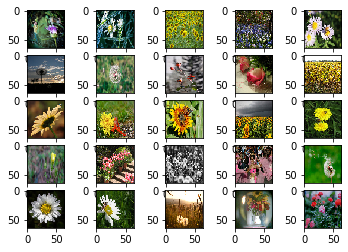

In [22]:
print(images.shape)
print(labels.shape)

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(images[0,np.random.randint(3500),:,:,:].astype('uint8'))
images = images/255.

Define Generator

In [0]:
def createGenerator():
  generator = tf.keras.Sequential()

  # first densely connected network to upscale the image to required dimension
  generator.add(layers.Dense(16*16*64,use_bias=False,input_shape = (NOISE,)))
  generator.add(layers.BatchNormalization())
  generator.add(layers.LeakyReLU())


  generator.add(layers.Reshape((16,16,64)))
  assert generator.output_shape == (None,16,16,64)

  generator.add(layers.Conv2DTranspose(32,(5,5),strides=(1,1),use_bias=False,padding='same'))
  generator.add(layers.BatchNormalization())
  generator.add(layers.LeakyReLU())
  assert generator.output_shape == (None,16,16,32)

  generator.add(layers.Conv2DTranspose(16,(5,5),strides=(2,2),use_bias=False,padding='same'))
  generator.add(layers.LeakyReLU())

  generator.add(layers.Conv2DTranspose(3,(5,5),strides=(2,2),use_bias=False,padding='same',activation = 'tanh'))
  assert generator.output_shape == (None, 64, 64, 3)

  generator.summary()
  return generator

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 16384)             8192000   
_________________________________________________________________
batch_normalization_10 (Batc (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_15 (Conv2DT (None, 16, 16, 32)        51200     
_________________________________________________________________
batch_normalization_11 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
leaky_re_lu_22 (LeakyReLU)   (None, 16, 16, 32)       

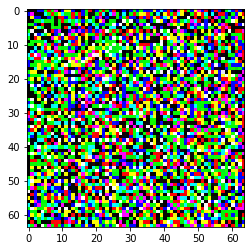

In [38]:
generator = createGenerator()
#generate noise to feed the generator
generated_noise = tf.random.normal([1,NOISE])

generated_image = generator(generated_noise, training=False)

#convert it to array for storing

arr = (np.asarray(generated_image)*255).astype('uint8')
# check the images
plt.imshow(arr[0,:,:,:])

Define Discriminator

In [0]:
def createDiscriminator():
  model = tf.keras.Sequential()

  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',input_shape=[64, 64, 3]))
  print(model.output_shape)
  
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  
  model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  print(model.output_shape)

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  model.summary()
  return model

Make Generator and Discriminator

In [34]:
discriminator= createDiscriminator()
prediction = discriminator(generated_image)
print(prediction)

(None, 32, 32, 64)
(None, 16, 16, 64)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        4864      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatt

In [0]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Losses and optimizers

In [0]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
    
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


seed = tf.random.normal([16, NOISE])

make GAN and compile it

In [0]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, NOISE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training = False)
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

      gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Train Gan Function

In [0]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [0]:
train(images, 500)

Time for epoch 1 is 1.0870542526245117 sec
Time for epoch 2 is 0.2675790786743164 sec
Time for epoch 3 is 0.24200868606567383 sec
Time for epoch 4 is 0.24976491928100586 sec
Time for epoch 5 is 0.24903512001037598 sec
Time for epoch 6 is 0.25129222869873047 sec
Time for epoch 7 is 0.24994850158691406 sec
Time for epoch 8 is 0.25101470947265625 sec
Time for epoch 9 is 0.24857521057128906 sec
Time for epoch 10 is 0.25145769119262695 sec
Time for epoch 11 is 0.2503693103790283 sec
Time for epoch 12 is 0.25221681594848633 sec
Time for epoch 13 is 0.2504887580871582 sec
Time for epoch 14 is 0.2520148754119873 sec
Time for epoch 15 is 0.2550675868988037 sec
Time for epoch 16 is 0.2513566017150879 sec
Time for epoch 17 is 0.2501060962677002 sec
Time for epoch 18 is 0.2672696113586426 sec
Time for epoch 19 is 0.2405991554260254 sec
Time for epoch 20 is 0.2593240737915039 sec
Time for epoch 21 is 0.25779080390930176 sec
Time for epoch 22 is 0.2306530475616455 sec
Time for epoch 23 is 0.25761175

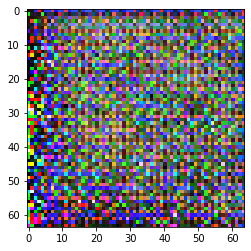

In [51]:
#generate noise to feed the generator
generated_noise = tf.random.normal([1,NOISE])
generated_image = generator(generated_noise, training=False)
#convert it to array for storing
arr = np.asarray(generated_image)*255
# check the images
plt.imshow(arr[0,:,:,:].astype('uint8'))

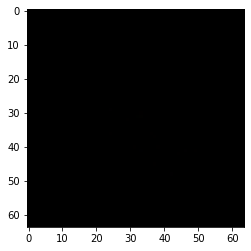

In [0]:
x = np.random.randint(3550)
plt.imshow(images[0,x,:,:,:].astype('uint8'))

In [0]:
discriminator.compile(optimizer = 'Adam', loss= 'binary_crossentropy')